## Clustering Analyisis - 2 point correlation function of the HSB sample

In this notebook I analyse the 2 point correlation function of the three HSB samples and compare them to that of the LSB sample.

In each case the errors are estimated using the jackknife approach; For $N$ jackknife resamplings, the estimation of the covariance is:

\begin{equation}
C_{ij} = \frac{N-1}{N} \sum_{k=1}^N (x_i^k - \bar{x}_i)(x_j^k - \bar{x}_j)
\end{equation}

where:

\begin{equation}
\bar{x}_i = \frac{1}{N}\sum_{k=1}^N x_i^k
\end{equation}

In [271]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [272]:
import treecorr
import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

### Write a function that calculates Jackknife errors, given a data catalog and a random catalog

In [273]:
def Jackknife(ra_dat, dec_dat, ra_rand, dec_rand, N_samples):
    """
    Inputs
    ------------------------------------------
    ra_dat: the ra of the data catalog
    dec_dat: the dec of the data catalog
     
    ra_rand: the ra of the random catalog
    dec_rand: the dac of the random catalog
    
    Outputs
    ------------------------------------------
    Errors in the two-point calculation across different scales
    """
    
    # First of all create array to store the results of the evaluations of 
    # the two point correlation functions
    Xi_vect = np.zeros([N_samples,20]) 
    
    #Create array with length equal to the length of the sample and entries 0,1,...,len(sample)
    len_smpl = len(ra_dat) #length of the sample
    
    A = np.arange(len_smpl)
    #Create array where you randomly redistribute these 
    np.random.shuffle(A)
    
    #randomize the distribution of the ra, dec vectors of the data
    ra_dat_rn = ra_dat[A]
    dec_dat_rn = dec_dat[A]
    
    # Batch size
    batch = int(len_smpl/N_samples)
    
    # =====================================================================
    # =====================================================================
    
    # Let's make a catalog for the randoms
    rand = treecorr.Catalog(ra=ra_rand, dec=dec_rand, ra_units='radians', dec_units='radians')
    rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
    rr.process(rand)
    
    # =====================================================================
    # =====================================================================
    #Populate the Xi_vect
    for i in range(N_samples):
        # Points to keep
        init = i*batch #Initial points not to keep
        fin = (i+1)*batch #final points not to keep
        
        # Keep data where you have excluded one batch 
        ra_dat_loc = np.concatenate((ra_dat_rn[:init],ra_dat_rn[fin:]))
        dec_dat_loc = np.concatenate((dec_dat_rn[:init],dec_dat_rn[fin:]))
        
        # Create catalog using the above data 
        cat_dat_loc = treecorr.Catalog(ra=ra_dat_loc, dec=dec_dat_loc, ra_units='deg', dec_units='deg')
        dd_loc = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
        dd_loc.process(cat_dat_loc)
        
        #data - random catalog
        dr_loc = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
        dr_loc.process(cat_dat_loc, rand)
        
        # Calculate 2pt correlation function of the sample
        xi_loc, varxi_loc = dd_loc.calculateXi(rr, dr_loc)
        
        Xi_vect[i,:] = xi_loc
    
        
    # ======================================================================
    # ======================================================================
    # Define vector to store the errors
    Err_vect = np.zeros(20)
    
    for i in range(20):
        
        Xi_i = Xi_vect[:,i]
        mean_Xi_i = np.mean(Xi_i)
        diff_sq = (Xi_i - mean_Xi_i)**2.0
        sig_sq = ((N_samples - 1.0)/N_samples)*np.sum(diff_sq)

        Err_vect[i] = np.sqrt(sig_sq)
    
    return Err_vect
    

###  Create a random catalog - it will useful anyway

In [274]:
# Open MAP 
# ==========================================
MAP = hp.read_map('y3a2_footprint_grizY_any.fits')

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


Create a random catalog that covers the footprint.

In [275]:
conv = np.pi/180.
ra_min = -70.0*conv
ra_max = 110.*conv
dec_min = -70.*conv
dec_max = 10.*conv
# ========================
# ========================
rand_ra = np.random.uniform(ra_min, ra_max, 10**7)
rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), 10**7)
rand_dec = np.arcsin(rand_sindec)
# ========================

In [276]:
# Get the healpix indices of the randoms
HP_ind_rand = hp.ang2pix(4096, rand_ra/conv, rand_dec/conv, lonlat=True)

In [277]:
# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1
# =====================================
# =====================================

In [278]:
# Keep only those with randoms for which the value of the des mask 
# ===============================================
# ===============================================
# Keep local mask
LOCAL_mask_rand = DES_mask[HP_ind_rand]

# Keep those with LOCAL_mask = 1
rand_ra_pos = rand_ra[LOCAL_mask_rand==1]
rand_dec_pos = rand_dec[LOCAL_mask_rand==1]

In [279]:
print(len(rand_ra_pos))

4570824


In [280]:
# Let's make a catalog for the randoms
rand = treecorr.Catalog(ra=rand_ra_pos, dec=rand_dec_pos, ra_units='radians', dec_units='radians')
rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
rr.process(rand)

### Import the HSB catalog

In [281]:
# Open and read the HSB galaxies catalog
HSB_gal = fits.open('HSB_3.fits')

#print HSB_gal[1].header.keys

In [282]:
ra_HSB = HSB_gal[1].data['RA']
dec_HSB = HSB_gal[1].data['DEC']
Z_BPZ_HSB = HSB_gal[1].data['BPZ_ZMEAN_MOF']
MU_MEAN_G_HSB = HSB_gal[1].data['MU_MEAN_MODEL_G']
mag_i_HSB = HSB_gal[1].data['MAG_AUTO_I']
mag_g_HSB = HSB_gal[1].data['MAG_AUTO_G']
col_g_i_HSB = mag_g_HSB - mag_i_HSB

for i in range(len(ra_HSB)):
    if (ra_HSB[i] > 150.):
        ra_HSB[i] = ra_HSB[i]-360.

### Import the LSB catalog

In [283]:
# Import (and plot for visualization reasons) the coordinates of the LSBGs objects
ra, dec= np.loadtxt("LSBGs_properties_tot.dat", usecols=(1,2), unpack=3)
flux_rad_g = np.loadtxt("LSBGs_properties_tot.dat", usecols=(6), unpack=3)
# Load the magnitudes to calculate colors
mag_g, mag_r, mag_i = np.loadtxt("LSBGs_properties_tot.dat", usecols=(5,11,17), unpack=3)

# Define the colors here
col_g_i = mag_g - mag_i
col_g_r = mag_g - mag_r
col_i_r = mag_i - mag_r
# ==================================================================
# ==================================================================
for i in range(len(ra)):
    if (ra[i] > 150.):
        ra[i] = ra[i]-360.       

### Calculate 2pt function of the LSBG catalog

In [284]:
# Create catalog
cat_LSBG = treecorr.Catalog(ra=ra, dec=dec, ra_units='deg', dec_units='deg')
dd_LSBG = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dd_LSBG.process(cat_LSBG)
# ===========================================================
# ===========================================================
dr_LSBG = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dr_LSBG.process(cat_LSBG, rand)
# ===========================================================
# Calculate 2pt correlation function of the total sample
xi_LSBG, varxi_LSBG = dd_LSBG.calculateXi(rr, dr_LSBG)
r_LSBG = np.exp(dd_LSBG.meanlogr)

In [285]:
# Calculate Jackknife errors
# Calculate LSBG errors
Errors_LSBG = Jackknife(ra, dec, rand_ra_pos, rand_dec_pos, 100)

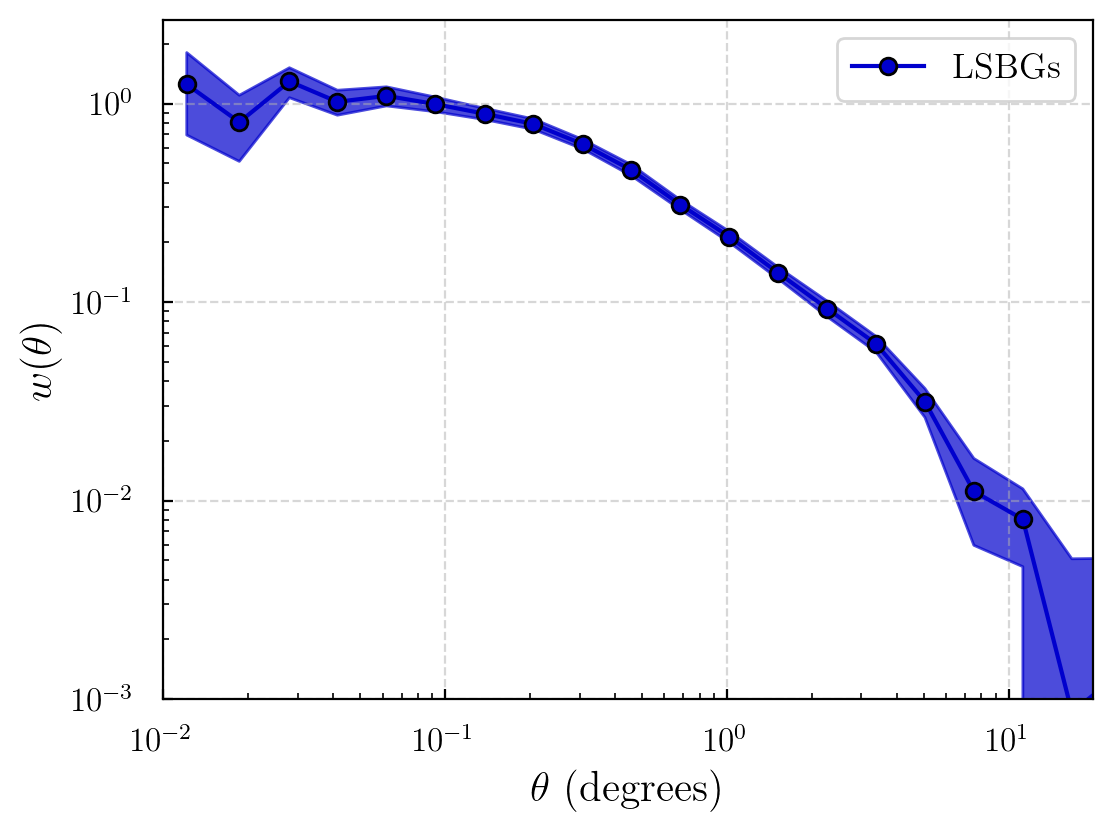

In [286]:
plt.figure(figsize = (6.0,4.5))


# LSBG galaxies
plt.plot(r_LSBG, xi_LSBG, color='mediumblue',marker='o', markeredgecolor='k', label='LSBGs')
plt.plot(r_LSBG, -xi_LSBG, color='mediumblue',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_LSBG, xi_LSBG-Errors_LSBG, xi_LSBG+Errors_LSBG, color='mediumblue', alpha=0.7)



plt.grid(ls='--',alpha=0.5)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)', fontsize=15)



plt.ylabel(r'$w(\theta)$', fontsize=15)
plt.legend(frameon=True, loc='upper right', fontsize=13)
plt.xlim([0.01,20]);plt.ylim(1.0e-3)
plt.tick_params(axis='both', labelsize=12)

plt.show()

In [287]:
import scipy.stats as stats
mag_cut = (mag_g>18)&(mag_g<22)
density = stats.gaussian_kde(mag_g[mag_cut])

In [288]:
y_like_g, x_like_g = np.histogram(mag_g[mag_cut], bins=50, density=True)

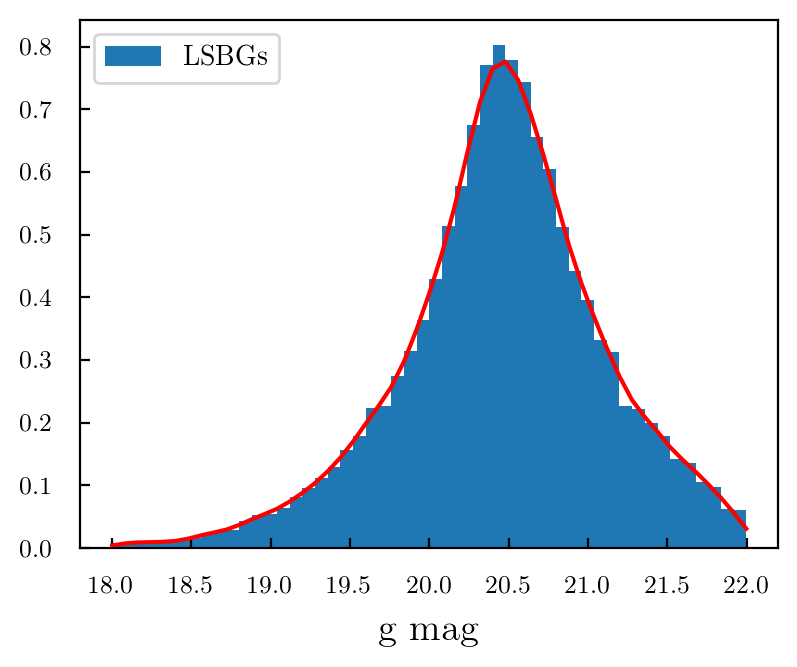

In [289]:
plt.figure(figsize = (4.5,3.5))

plt.hist(mag_g[mag_cut], bins =50,density=True, label='LSBGs')
plt.plot(x_like_g,density(x_like_g), c='r')


plt.xlabel('g mag', fontsize=14)
plt.legend(frameon=True, loc='upper left', fontsize=10)
plt.show()

In [290]:
ra_HSB = HSB_gal[1].data['RA']
dec_HSB = HSB_gal[1].data['DEC']
Z_BPZ_HSB = HSB_gal[1].data['BPZ_ZMEAN_MOF']
MU_MEAN_G_HSB = HSB_gal[1].data['MU_MEAN_MODEL_G']
mag_i_HSB = HSB_gal[1].data['MAG_AUTO_I']
mag_g_HSB = HSB_gal[1].data['MAG_AUTO_G']
col_g_i_HSB = mag_g_HSB - mag_i_HSB

for i in range(len(ra_HSB)):
    if (ra_HSB[i] > 150.):
        ra_HSB[i] = ra_HSB[i]-360.
        
        
        
ra_HSB= ra_HSB[(Z_BPZ_HSB>0.2)&(Z_BPZ_HSB<0.4)]
dec_HSB= dec_HSB[(Z_BPZ_HSB>0.2)&(Z_BPZ_HSB<0.4)]
mag_g_HSB = mag_g_HSB[(Z_BPZ_HSB>0.2)&(Z_BPZ_HSB<0.4)]

In [291]:
mag_cut_n = (mag_g>18)&(mag_g<22)
y_like_g_LSB, x_like_g_LSB = np.histogram(mag_g[mag_cut_n], bins=100, density=False)  
y_like_g_HSB, x_like_g_HSB = np.histogram(mag_g_HSB, bins=100, density=False)
ratio = np.array(y_like_g_LSB, dtype=float)/np.array(y_like_g_HSB, dtype=float)
#print(ratio)

In [292]:
n_bins = len(y_like_g_LSB)
dx = x_like_g_LSB[1] - x_like_g_LSB[0]

ra_redist = []
dec_redist = []
mag_redist = []

for i in range(n_bins):
    # Upper and lower limits of the bins
    mag_low = x_like_g_LSB[i]
    mag_up = x_like_g_LSB[i+1]
    # ==================================
    # ==================================
    # Define here the magnitude cut for the prsent bin
    mag_cut = (mag_g_HSB>mag_low)&(mag_g_HSB<mag_up)
    
    
    
    mag_loc = mag_g_HSB[mag_cut]
    ra_loc = ra_HSB[mag_cut]
    dec_loc = dec_HSB[mag_cut]
    
    # ===================================================
    # Shuffle now
    N_loc = len(mag_loc)
    
    A_arr = np.arange(N_loc)
    
    np.random.shuffle(A_arr)
    mag_loc = mag_loc[A_arr]
    ra_loc = ra_loc[A_arr]
    dec_loc = dec_loc[A_arr]
    # ===================================================
    # ===================================================
    # Define size
    N_keep = 5*int(ratio[i]*N_loc)
    
    # Now keep only those from zero to N_keep
    mag_loc = mag_loc[0:N_keep]
    ra_loc = ra_loc[0:N_keep]
    dec_loc = dec_loc[0:N_keep]
    # ===================================================
    # ===================================================
    ra_redist = np.concatenate((ra_redist,ra_loc))
    dec_redist = np.concatenate((dec_redist,dec_loc))
    mag_redist = np.concatenate((mag_redist,mag_loc))
    

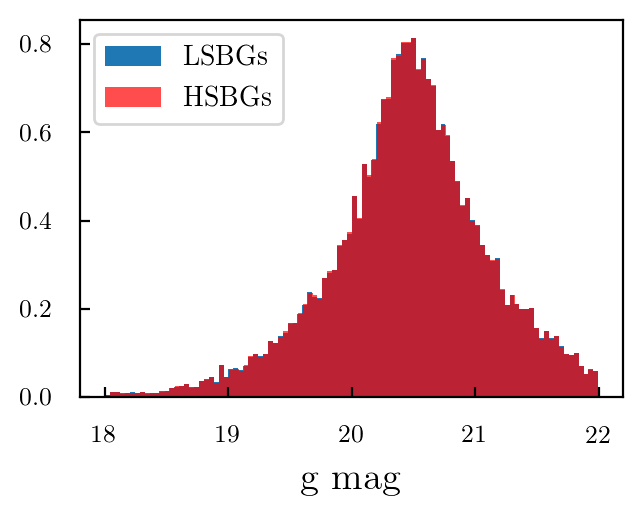

In [293]:
mag_cut_n = (mag_g>18)&(mag_g<22)
plt.figure(figsize = (3.5,2.5))

plt.hist(mag_g[mag_cut_n], bins =100, density=True, label='LSBGs')
plt.hist(mag_redist, bins =100,color='r',alpha=0.7, density=True, label='HSBGs')



plt.xlabel('g mag', fontsize=14)
plt.legend(frameon=True, loc='upper left', fontsize=10)
plt.show()

### Calculate 2pt of HSB

In [294]:
# Create catalog
cat_HSB = treecorr.Catalog(ra=ra_redist, dec=dec_redist, ra_units='deg', dec_units='deg')
dd_HSB = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dd_HSB.process(cat_HSB)
# ===========================================================
# ===========================================================
dr_HSB = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dr_HSB.process(cat_HSB, rand)
# ===========================================================
# Calculate 2pt correlation function of the total sample
xi_HSB, varxi_HSB = dd_HSB.calculateXi(rr, dr_HSB)
r_HSB = np.exp(dd_HSB.meanlogr)

In [295]:
# Calculate Jackknife errors
# Calculate LSBG errors
Errors_HSB = Jackknife(ra_redist, dec_redist, rand_ra_pos, rand_dec_pos, 50)

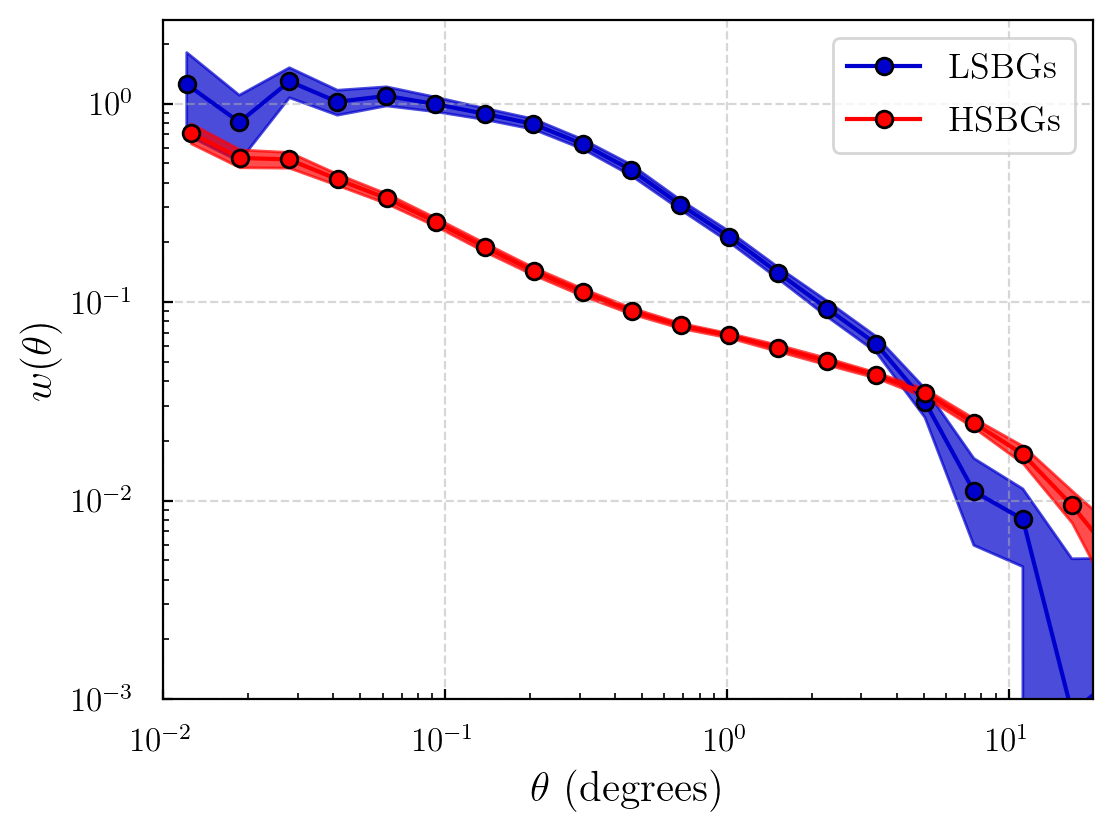

In [296]:
plt.figure(figsize = (6.0,4.5))


# LSBG galaxies
plt.plot(r_LSBG, xi_LSBG, color='mediumblue',marker='o', markeredgecolor='k', label='LSBGs')
plt.plot(r_LSBG, -xi_LSBG, color='mediumblue',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_LSBG, xi_LSBG-Errors_LSBG, xi_LSBG+Errors_LSBG, color='mediumblue', alpha=0.7)


plt.plot(r_HSB, xi_HSB, color='red',marker='o', markeredgecolor='k', label='HSBGs')
plt.plot(r_HSB, -xi_HSB, color='red',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_HSB, xi_HSB-Errors_HSB, xi_HSB+Errors_HSB, color='red', alpha=0.7)

plt.grid(ls='--',alpha=0.5)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)', fontsize=15)



plt.ylabel(r'$w(\theta)$', fontsize=15)
plt.legend(frameon=True, loc='upper right', fontsize=13)
plt.xlim([0.01,20]);plt.ylim(1.0e-3)
plt.tick_params(axis='both', labelsize=12)

plt.show()

In [297]:
ra_HSB = HSB_gal[1].data['RA']
dec_HSB = HSB_gal[1].data['DEC']
Z_BPZ_HSB = HSB_gal[1].data['BPZ_ZMEAN_MOF']
MU_MEAN_G_HSB = HSB_gal[1].data['MU_MEAN_MODEL_G']
mag_i_HSB = HSB_gal[1].data['MAG_AUTO_I']
mag_g_HSB = HSB_gal[1].data['MAG_AUTO_G']
col_g_i_HSB = mag_g_HSB - mag_i_HSB

for i in range(len(ra_HSB)):
    if (ra_HSB[i] > 150.):
        ra_HSB[i] = ra_HSB[i]-360.
        
        
        
ra_HSB= ra_HSB[Z_BPZ_HSB<0.11]
dec_HSB= dec_HSB[Z_BPZ_HSB<0.11]
mag_g_HSB = mag_g_HSB[Z_BPZ_HSB<0.11]

In [298]:
mag_cut_n = (mag_g>18)&(mag_g<22)
y_like_g_LSB, x_like_g_LSB = np.histogram(mag_g[mag_cut_n], bins=100, density=False)  
y_like_g_HSB, x_like_g_HSB = np.histogram(mag_g_HSB, bins=100, density=False)
ratio = np.array(y_like_g_LSB, dtype=float)/np.array(y_like_g_HSB, dtype=float)
#print(ratio)

In [299]:
n_bins = len(y_like_g_LSB)
dx = x_like_g_LSB[1] - x_like_g_LSB[0]

ra_redist = []
dec_redist = []
mag_redist = []

for i in range(n_bins):
    # Upper and lower limits of the bins
    mag_low = x_like_g_LSB[i]
    mag_up = x_like_g_LSB[i+1]
    # ==================================
    # ==================================
    # Define here the magnitude cut for the prsent bin
    mag_cut = (mag_g_HSB>mag_low)&(mag_g_HSB<mag_up)
    
    
    
    mag_loc = mag_g_HSB[mag_cut]
    ra_loc = ra_HSB[mag_cut]
    dec_loc = dec_HSB[mag_cut]
    
    # ===================================================
    # Shuffle now
    N_loc = len(mag_loc)
    
    A_arr = np.arange(N_loc)
    
    np.random.shuffle(A_arr)
    mag_loc = mag_loc[A_arr]
    ra_loc = ra_loc[A_arr]
    dec_loc = dec_loc[A_arr]
    # ===================================================
    # ===================================================
    # Define size
    N_keep = 5*int(ratio[i]*N_loc)
    
    # Now keep only those from zero to N_keep
    mag_loc = mag_loc[0:N_keep]
    ra_loc = ra_loc[0:N_keep]
    dec_loc = dec_loc[0:N_keep]
    # ===================================================
    # ===================================================
    ra_redist = np.concatenate((ra_redist,ra_loc))
    dec_redist = np.concatenate((dec_redist,dec_loc))
    mag_redist = np.concatenate((mag_redist,mag_loc))
    

In [300]:
# Create catalog
cat_HSB_2 = treecorr.Catalog(ra=ra_redist, dec=dec_redist, ra_units='deg', dec_units='deg')
dd_HSB_2= treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dd_HSB_2.process(cat_HSB_2)
# ===========================================================
# ===========================================================
dr_HSB_2 = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dr_HSB_2.process(cat_HSB_2, rand)
# ===========================================================
# Calculate 2pt correlation function of the total sample
xi_HSB_2, varxi_HSB_2 = dd_HSB_2.calculateXi(rr, dr_HSB_2)
r_HSB_2 = np.exp(dd_HSB_2.meanlogr)

In [301]:
# Calculate Jackknife errors
# Calculate LSBG errors
Errors_HSB_2= Jackknife(ra_redist, dec_redist, rand_ra_pos, rand_dec_pos, 50)

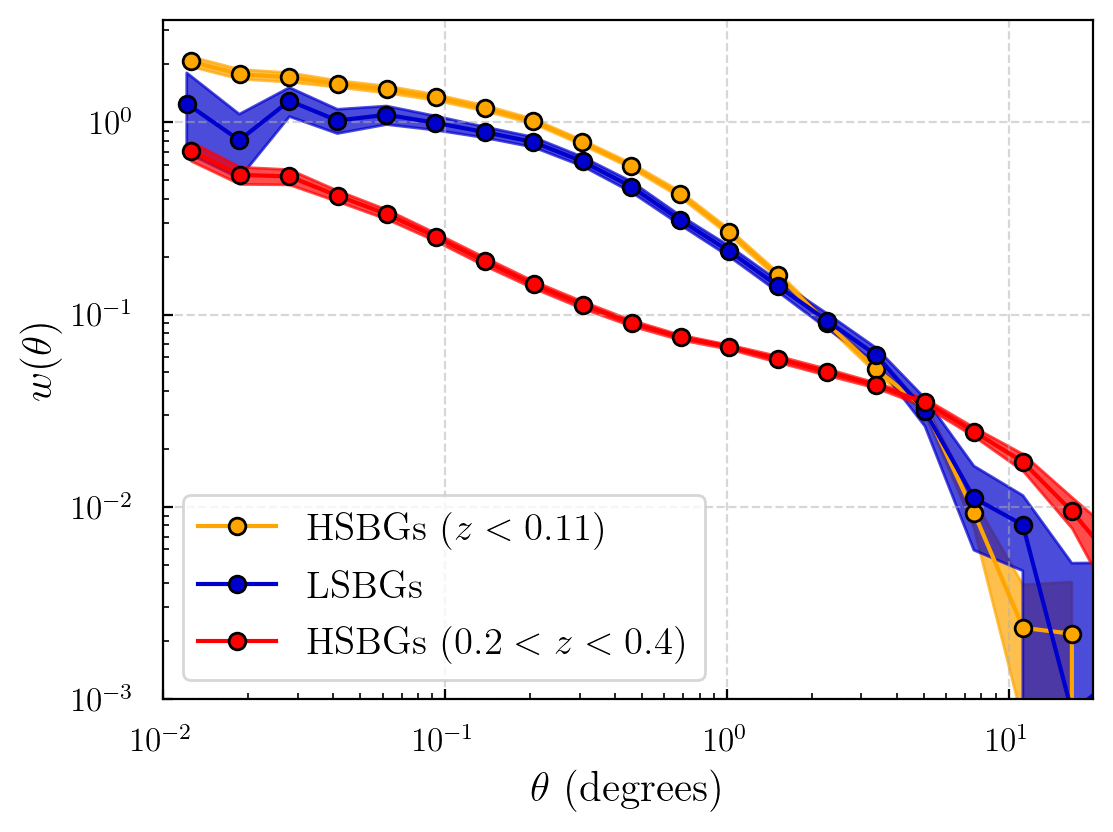

In [302]:
plt.figure(figsize = (6.0,4.5))


# HSB
plt.plot(r_HSB_2, xi_HSB_2, color='orange',marker='o', markeredgecolor='k', label='HSBGs $(z<0.11)$')
plt.plot(r_HSB_2, -xi_HSB_2, color='orange',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_HSB_2, xi_HSB_2-Errors_HSB_2, xi_HSB_2+Errors_HSB_2, color='orange', alpha=0.7)

# LSBG galaxies
plt.plot(r_LSBG, xi_LSBG, color='mediumblue',marker='o', markeredgecolor='k', label='LSBGs')
plt.plot(r_LSBG, -xi_LSBG, color='mediumblue',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_LSBG, xi_LSBG-Errors_LSBG, xi_LSBG+Errors_LSBG, color='mediumblue', alpha=0.7)

# HSB
plt.plot(r_HSB, xi_HSB, color='red',marker='o', markeredgecolor='k', label='HSBGs $(0.2< z < 0.4)$')
plt.plot(r_HSB, -xi_HSB, color='red',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_HSB, xi_HSB-Errors_HSB, xi_HSB+Errors_HSB, color='red', alpha=0.7)



plt.grid(ls='--',alpha=0.5)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)', fontsize=15)



plt.ylabel(r'$w(\theta)$', fontsize=15)
plt.legend(frameon=True, loc='lower left', fontsize=14)
plt.xlim([0.01,20]);plt.ylim(1.0e-3)
plt.tick_params(axis='both', labelsize=12)
plt.savefig('two_point_function_HSB.pdf', dpi=300)
plt.show()

### Cross correlation of the HSB sample and the LSB sample

Here I calculate the cross correlation between the HSB that gave the best match ($z<0.11$) and the LSB galaxies.

In [311]:
# Create catalogs for the LSB galaxies and the HSB galaxies
# =========================================================
# =========================================================
cat_LSB = treecorr.Catalog(ra=ra, dec=dec, ra_units='deg', dec_units='deg') # Catalog for the LSBGs
cat_HSB = treecorr.Catalog(ra=ra_redist, dec=dec_redist, ra_units='deg', dec_units='deg') # Catalog for the HSBGs

In [312]:
# Process them - Create DD (data-data object)
DD = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
DD.process(cat_LSB,cat_HSB)

#### Create a random catalog for the HSBGs

We have created a random catalog for the LSB galaxies. Let's now create random catalog for the HSB galaxies.

In [313]:
# ======================================
rand_ra_HSB = np.random.uniform(ra_min, ra_max, 10**7)
rand_sindec_HSB = np.random.uniform(np.sin(dec_min), np.sin(dec_max), 10**7)
rand_dec_HSB = np.arcsin(rand_sindec_HSB)
# ======================================
# ======================================
# Get the healpix indices of the randoms
HP_ind_HSB = hp.ang2pix(4096, rand_ra_HSB/conv, rand_dec_HSB/conv, lonlat=True)

In [314]:
# Keep only those with randoms for which the value of the des mask 
# ===============================================
# ===============================================
# Keep local mask
LOCAL_mask_HSB = DES_mask[HP_ind_HSB]

# Keep those with LOCAL_mask = 1
rand_ra_pos_HSB = rand_ra_HSB[LOCAL_mask_HSB==1]
rand_dec_pos_HSB = rand_dec_HSB[LOCAL_mask_HSB==1]

In [315]:
# Create the random catalog
rand_HSB = treecorr.Catalog(ra=rand_ra_pos_HSB, dec=rand_dec_pos_HSB, ra_units='radians', dec_units='radians')

In [316]:
RR = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
RR.process(rand, rand_HSB)

# Create the RD and DR (cross catalogs)
# ===============================================================
# ===============================================================
# random - data 
RD = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
RD.process(cat_LSB, rand_HSB)

# data - randomRR = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
RR.process(rand, rand_HSB)

# Create the RD and DR (cross catalogs)
# ===============================================================
# ===============================================================
# random - data 
RD = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
RD.process(cat_LSB, rand_HSB)

# data - random
DR = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
DR.process(cat_HSB, rand)
DR = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
DR.process(cat_HSB, rand)

In [317]:
xi, varxi = DD.calculateXi(RR, DR, RD)
r = np.exp(DD.meanlogr)
sig = np.sqrt(varxi)

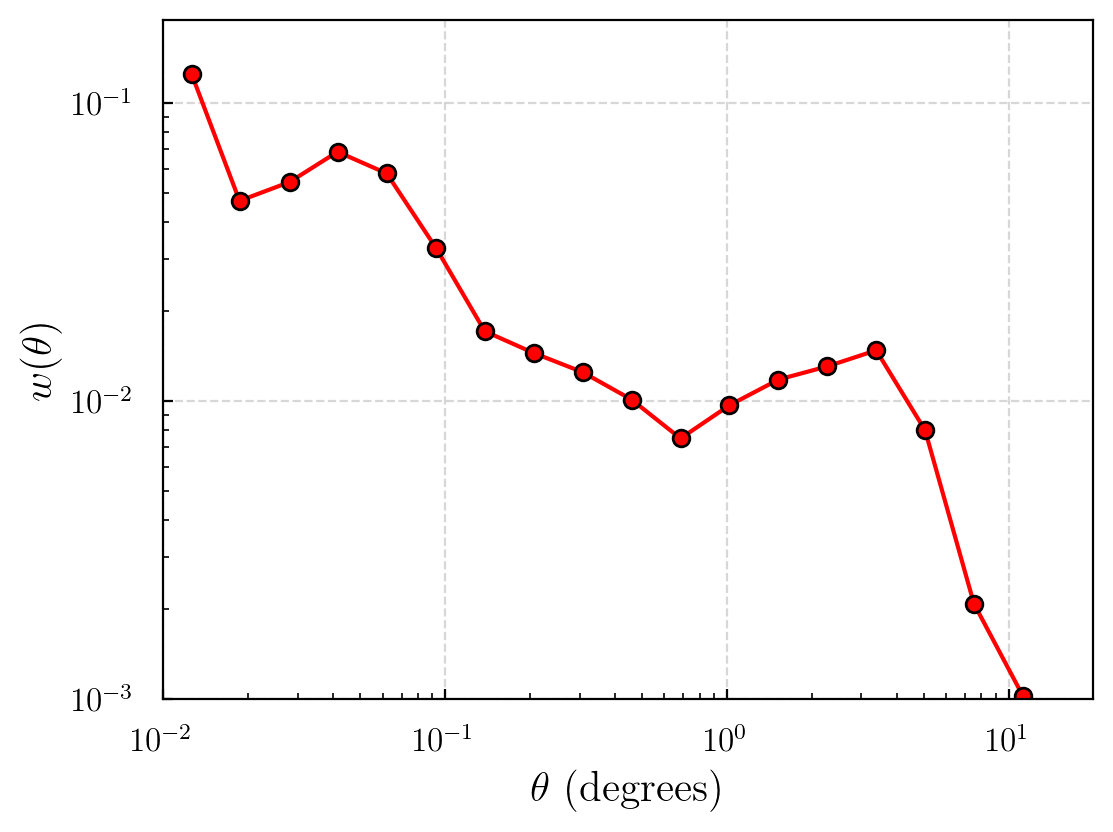

In [318]:
plt.figure(figsize = (6.0,4.5))





plt.plot(r, xi, color='red',marker='o', markeredgecolor='k')
plt.plot(r, -xi, color='red',marker='o', markeredgecolor='k', ls=':')
#plt.fill_between(r_HSB, xi_HSB-Errors_HSB, xi_HSB+Errors_HSB, color='red', alpha=0.7)



plt.grid(ls='--',alpha=0.5)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)', fontsize=15)



plt.ylabel(r'$w(\theta)$', fontsize=15)
#plt.legend(frameon=True, loc='lower left', fontsize=14)
plt.xlim([0.01,20]);plt.ylim(1.0e-3)
plt.tick_params(axis='both', labelsize=12)
#plt.savefig('two_point_function_HSB.pdf', dpi=300)
plt.show()

Repeat the two-point auto-correlation calculation (with $z < 0.11$), but this time include all galaxies (not just those that follow the same magnitude distribution).

In [319]:
# Create catalog
cat_HSB_3 = treecorr.Catalog(ra=ra_HSB, dec=dec_HSB, ra_units='deg', dec_units='deg')
dd_HSB_3= treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dd_HSB_3.process(cat_HSB_3)
# ===========================================================
# ===========================================================
dr_HSB_3 = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dr_HSB_3.process(cat_HSB_3, rand)
# ===========================================================
# Calculate 2pt correlation function of the total sample
xi_HSB_3, varxi_HSB_3 = dd_HSB_3.calculateXi(rr, dr_HSB_3)
r_HSB_3 = np.exp(dd_HSB_3.meanlogr)

In [321]:
# Calculate Jackknife errors
# Calculate LSBG errors
Errors_HSB_3= Jackknife(ra_HSB, dec_HSB, rand_ra_pos, rand_dec_pos, 30)

#### Calculate the auto correlation function of the 2MPZ (for $z<0.11$) as well

In [325]:
# Open and read the 2MPZ catalog
mpz_cat = fits.open('2MPZ.fits')
#mpz_cat[1].header.keys

# Convert to rad 
rad_to_deg = 180.0/np.pi
ra_mpz = rad_to_deg*mpz_cat[1].data['RA']
dec_mpz = rad_to_deg*mpz_cat[1].data['DEC']
z_mpz = mpz_cat[1].data['ZPHOTO']

for i in range(len(ra_mpz)):
    if (ra_mpz[i] > 150.):
        ra_mpz[i] = ra_mpz[i]-360.
        
# Keep only those in the box (-70,110)&(-70,10)
box = (ra_mpz>-70.0)&(ra_mpz<110.)&(dec_mpz>-70.0)&(dec_mpz<10.0)

ra_mpz = ra_mpz[box]
dec_mpz = dec_mpz[box]
z_mpz = z_mpz[box]

# ===============================================
# ===============================================
# keep those with z<0.11

ra_mpz = ra_mpz[z_mpz<0.11]
dec_mpz = dec_mpz[z_mpz<0.11]

print(len(ra_mpz))

206859


In [327]:
# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1
# ======================================================
# ======================================================
# Get the healpix indices of the mpz galaxies
HP_ind_mpz = hp.ang2pix(4096, ra_mpz, dec_mpz, lonlat=True)


# ===============================================
# Keep local mask
LOCAL_mask_mpz = DES_mask[HP_ind_mpz]

# Keep those with LOCAL_mask = 1
ra_mpz_in = ra_mpz[LOCAL_mask_mpz==1]
dec_mpz_in = dec_mpz[LOCAL_mask_mpz==1]
#z_mpz_in = z_mpz[LOCAL_mask_mpz==1]

In [328]:
# Calculate the 2pt correlation for the 2mpz catalog
cat_mpz = treecorr.Catalog(ra=ra_mpz_in, dec=dec_mpz_in, ra_units='deg', dec_units='deg')
dd_mpz = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dd_mpz.process(cat_mpz)
dr_mpz = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dr_mpz.process(cat_mpz, rand)

In [329]:
# Calculate 2pt correlation function of the sample
xi_mpz, varxi_mpz = dd_mpz.calculateXi(rr, dr_mpz)
r = np.exp(dd_mpz.meanlogr)

In [330]:
# Calculate mpz errors
Errors_mpz = Jackknife(ra_mpz_in, dec_mpz_in, rand_ra_pos, rand_dec_pos, 100)

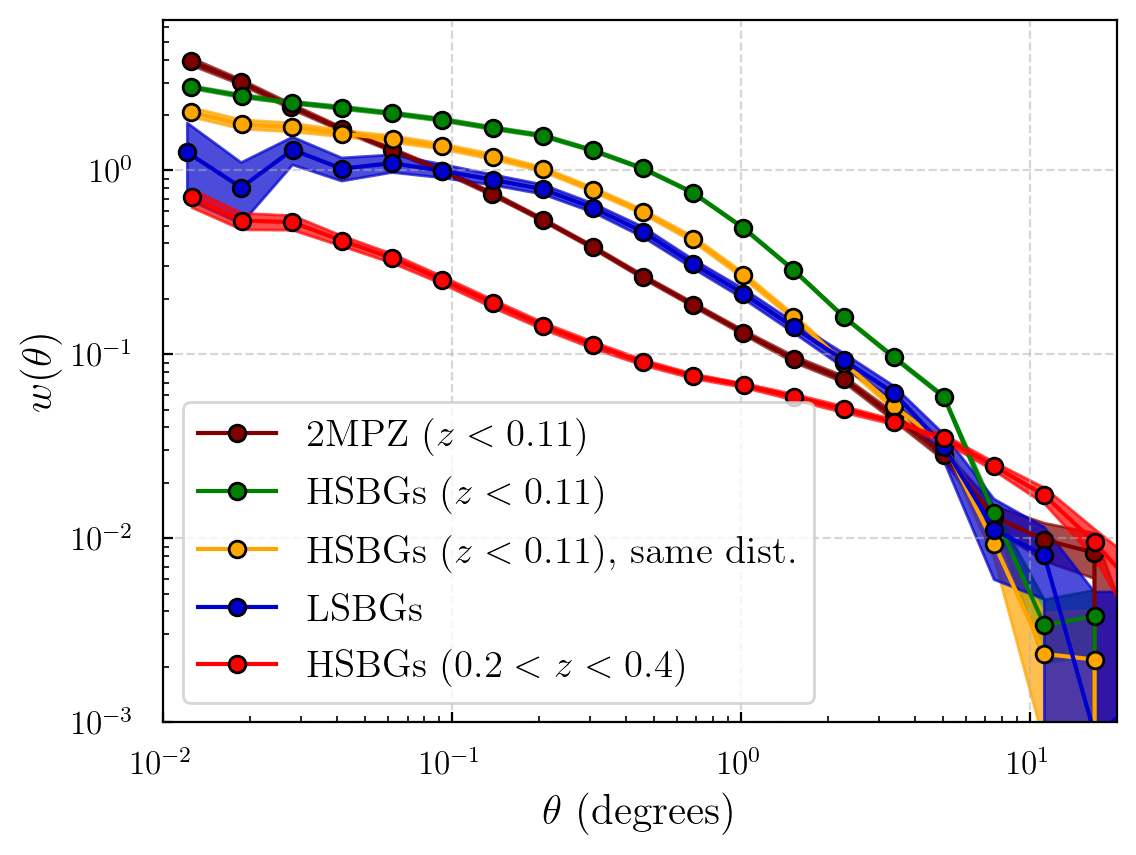

In [337]:
plt.figure(figsize = (6.15,4.65))

# 2MPZ
plt.plot(r, xi_mpz, color='maroon',marker='o', markeredgecolor='k', label='2MPZ $(z<0.11)$')
plt.plot(r, -xi_mpz, color='maroon',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r, xi_mpz-Errors_mpz, xi_mpz+Errors_mpz, color='maroon', alpha=0.7)

# HSB - all
plt.plot(r_HSB_3, xi_HSB_3, color='green',marker='o', markeredgecolor='k', label='HSBGs $(z < 0.11)$')
plt.plot(r_HSB_3, -xi_HSB_3, color='green',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_HSB_3, xi_HSB_3-Errors_HSB_3, xi_HSB_3+Errors_HSB_3, color='green', alpha=0.7)



# HSB
plt.plot(r_HSB_2, xi_HSB_2, color='orange',marker='o', markeredgecolor='k', label='HSBGs $(z<0.11)$, same dist.')
plt.plot(r_HSB_2, -xi_HSB_2, color='orange',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_HSB_2, xi_HSB_2-Errors_HSB_2, xi_HSB_2+Errors_HSB_2, color='orange', alpha=0.7)

# LSBG galaxies
plt.plot(r_LSBG, xi_LSBG, color='mediumblue',marker='o', markeredgecolor='k', label='LSBGs')
plt.plot(r_LSBG, -xi_LSBG, color='mediumblue',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_LSBG, xi_LSBG-Errors_LSBG, xi_LSBG+Errors_LSBG, color='mediumblue', alpha=0.7)

# HSB
plt.plot(r_HSB, xi_HSB, color='red',marker='o', markeredgecolor='k', label='HSBGs $(0.2< z < 0.4)$')
plt.plot(r_HSB, -xi_HSB, color='red',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_HSB, xi_HSB-Errors_HSB, xi_HSB+Errors_HSB, color='red', alpha=0.7)





plt.grid(ls='--',alpha=0.5)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)', fontsize=15)



plt.ylabel(r'$w(\theta)$', fontsize=15)
plt.legend(frameon=True, loc='lower left', fontsize=14)
plt.xlim([0.01,20]);plt.ylim(1.0e-3)
plt.tick_params(axis='both', labelsize=12)
#plt.savefig('two_point_function_HSB.pdf', dpi=300)
plt.show()

### And calculate the cross-correlations!

We have already calculated the cross correlation of the LSB sample with the HSB sample, let's calculate the cross correlation with the other samples as well.

##### First, cross correlation with the 2mpz

In [345]:
# Process them - Create DD (data-data object)
DD = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
DD.process(cat_LSB,cat_mpz)
# ===============================================================
# ===============================================================
RR = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
RR.process(rand, rand_HSB)

# Create the RD and DR (cross catalogs)
# ===============================================================
# ===============================================================
# random - data 
RD = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
RD.process(cat_LSB, rand_HSB)

# data - random
DR = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
DR.process(cat_mpz, rand)

# ==============================================================
# ==============================================================
xi_mpz, varxi_mpz = DD.calculateXi(RR, DR, RD)
r_mpz = np.exp(DD.meanlogr)
sig_mpz = np.sqrt(varxi_mpz)

##### Second, cross correlation with the full sample $z<0.11$

In [346]:
# Process them - Create DD (data-data object)
DD = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
DD.process(cat_LSB,cat_HSB_3)
# ===============================================================
# ===============================================================
RR = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
RR.process(rand, rand_HSB)

# Create the RD and DR (cross catalogs)
# ===============================================================
# ===============================================================
# random - data 
RD = treecorr.NNCorrelation(
    min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
RD.process(cat_LSB, rand_HSB)

# data - random
DR = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
DR.process(cat_HSB_3, rand)

# ==============================================================
# ==============================================================
xi_HSB_3, varxi_mpz = DD.calculateXi(RR, DR, RD)
r_HSB_3 = np.exp(DD.meanlogr)
sig_HSB_3 = np.sqrt(varxi_HSB_3)

#### Now those with $z>0.2$ and $z<0.4$.

In [348]:
ra_HSB = HSB_gal[1].data['RA']
dec_HSB = HSB_gal[1].data['DEC']
Z_BPZ_HSB = HSB_gal[1].data['BPZ_ZMEAN_MOF']
MU_MEAN_G_HSB = HSB_gal[1].data['MU_MEAN_MODEL_G']
mag_i_HSB = HSB_gal[1].data['MAG_AUTO_I']
mag_g_HSB = HSB_gal[1].data['MAG_AUTO_G']
col_g_i_HSB = mag_g_HSB - mag_i_HSB

for i in range(len(ra_HSB)):
    if (ra_HSB[i] > 150.):
        ra_HSB[i] = ra_HSB[i]-360.
        
        
        
ra_HSB= ra_HSB[(Z_BPZ_HSB>0.2)&(Z_BPZ_HSB<0.4)]
dec_HSB= dec_HSB[(Z_BPZ_HSB>0.2)&(Z_BPZ_HSB<0.4)]
mag_g_HSB = mag_g_HSB[(Z_BPZ_HSB>0.2)&(Z_BPZ_HSB<0.4)]

In [349]:
mag_cut_n = (mag_g>18)&(mag_g<22)
y_like_g_LSB, x_like_g_LSB = np.histogram(mag_g[mag_cut_n], bins=100, density=False)  
y_like_g_HSB, x_like_g_HSB = np.histogram(mag_g_HSB, bins=100, density=False)
ratio = np.array(y_like_g_LSB, dtype=float)/np.array(y_like_g_HSB, dtype=float)
#print(ratio)

In [350]:
n_bins = len(y_like_g_LSB)
dx = x_like_g_LSB[1] - x_like_g_LSB[0]

ra_redist = []
dec_redist = []
mag_redist = []

for i in range(n_bins):
    # Upper and lower limits of the bins
    mag_low = x_like_g_LSB[i]
    mag_up = x_like_g_LSB[i+1]
    # ==================================
    # ==================================
    # Define here the magnitude cut for the prsent bin
    mag_cut = (mag_g_HSB>mag_low)&(mag_g_HSB<mag_up)
    
    
    
    mag_loc = mag_g_HSB[mag_cut]
    ra_loc = ra_HSB[mag_cut]
    dec_loc = dec_HSB[mag_cut]
    
    # ===================================================
    # Shuffle now
    N_loc = len(mag_loc)
    
    A_arr = np.arange(N_loc)
    
    np.random.shuffle(A_arr)
    mag_loc = mag_loc[A_arr]
    ra_loc = ra_loc[A_arr]
    dec_loc = dec_loc[A_arr]
    # ===================================================
    # ===================================================
    # Define size
    N_keep = 5*int(ratio[i]*N_loc)
    
    # Now keep only those from zero to N_keep
    mag_loc = mag_loc[0:N_keep]
    ra_loc = ra_loc[0:N_keep]
    dec_loc = dec_loc[0:N_keep]
    # ===================================================
    # ===================================================
    ra_redist = np.concatenate((ra_redist,ra_loc))
    dec_redist = np.concatenate((dec_redist,dec_loc))
    mag_redist = np.concatenate((mag_redist,mag_loc))
    

In [353]:
# Create catalog
cat_HSB_4 = treecorr.Catalog(ra=ra_redist, dec=dec_redist, ra_units='deg', dec_units='deg')
# Process them - Create DD (data-data object)
DD = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
DD.process(cat_LSB,cat_HSB_4)
# ===============================================================
# ===============================================================
RR = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
RR.process(rand, rand_HSB)

# Create the RD and DR (cross catalogs)
# ===============================================================
# ===============================================================
# random - data 
RD = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
RD.process(cat_LSB, rand_HSB)

# data - random
DR = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
DR.process(cat_HSB_4, rand)

# ==============================================================
# ==============================================================
xi_HSB_4, varxi_HSB_4 = DD.calculateXi(RR, DR, RD)
r_HSB_4 = np.exp(DD.meanlogr)
sig_HSB_4 = np.sqrt(varxi_HSB_4)

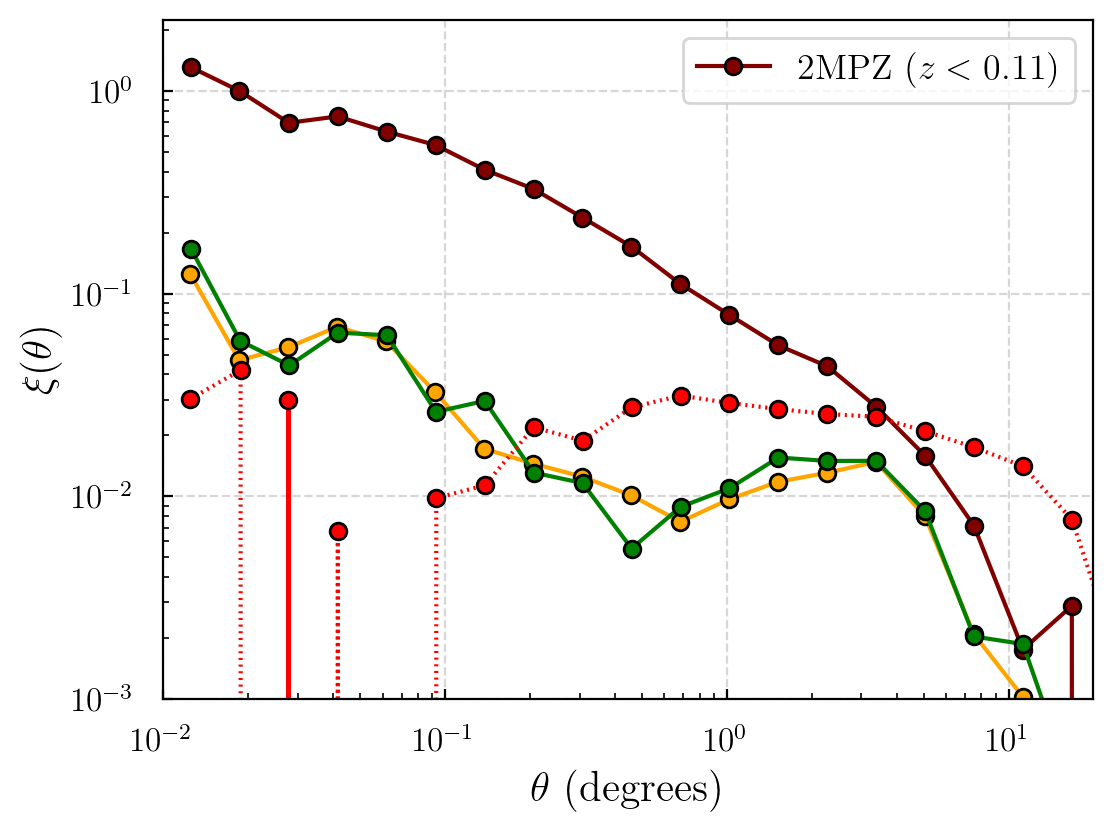

In [360]:
plt.figure(figsize = (6.0,4.5))

plt.plot(r_mpz, xi_mpz, color='maroon',marker='o', markeredgecolor='k', label='2MPZ $(z<0.11)$')
plt.plot(r_mpz, -xi_mpz, color='maroon',marker='o', markeredgecolor='k', ls=':')



plt.plot(r, xi, color='orange',marker='o', markeredgecolor='k')
plt.plot(r, -xi, color='orange',marker='o', markeredgecolor='k', ls=':')
#plt.fill_between(r_HSB, xi_HSB-Errors_HSB, xi_HSB+Errors_HSB, color='red', alpha=0.7)



plt.plot(r_HSB_3, xi_HSB_3, color='green',marker='o', markeredgecolor='k')
plt.plot(r_HSB_3, -xi_HSB_3, color='green',marker='o', markeredgecolor='k', ls=':')

plt.plot(r_HSB_4, xi_HSB_4, color='red',marker='o', markeredgecolor='k')
plt.plot(r_HSB_4, -xi_HSB_4, color='red',marker='o', markeredgecolor='k', ls=':')




plt.grid(ls='--',alpha=0.5)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)', fontsize=15)



plt.ylabel(r'$\xi(\theta)$', fontsize=15)
plt.legend(frameon=True, loc='upper right', fontsize=13)
plt.xlim([0.01,20]);plt.ylim(1.0e-3)
plt.tick_params(axis='both', labelsize=12)
#plt.savefig('two_point_function_HSB.pdf', dpi=300)
plt.show()